# Neural Green's Operators (NGOs) for the steady diffusion problem

Before running this notebook, be sure you installed the right packages according to the README.md. Running this notebook from top to bottom should give you within a few seconds a reasonably accurate trained model NGO, a plot of a true solution versus the model NGO prediction, and a plot of the prediction error of the model NGO versus the length scale of the test data. For higher accuracy, set the variables 'N_samples_train'=10000, 'N_samples_val'=1000 and 'epochs'=5000. For higher statistics in the error versus length scale plot, set the number of test data samples to 100 or 1000.

### Imports

In [83]:
from ngo.ml.trainer import train
from ngo.ml.customlosses import *
from ngo.ml.systemnets import *
from ngo.ml.basisfunctions import *
from ngo.ml.modelloader import *
from ngo.ml.quadrature import *
from ngo.testproblems.steadydiffusion.NeuralOperator import NeuralOperator
from ngo.testproblems.steadydiffusion.DataModule import DataModule
from ngo.testproblems.steadydiffusion.manufacturedsolutions import *
import matplotlib.pyplot as plt
hparams = {}

### Training data (manufactured solutions)

In [84]:
hparams['N_samples_train'] = 100 #Number of training samples, default is 10000
hparams['N_samples_val'] = 10 #Number of validation samples, default is 1000
hparams['variables'] = ['x','x'] #Variable types. 'x' for spatial variable, 't' for temporal variable
hparams['d'] = len(hparams['variables']) #Problem dimensionality
hparams['l_min'] = [0.5,0.5] #Minimum GRF length scale per dimension
hparams['l_max'] = [1,1] #Maximum GRF length scale per dimension

### Training settings

In [85]:
hparams['dtype'] = torch.float32 #Model dtype
hparams['precision'] = 32 #Keep the same as above
hparams['accelerator'] = 'cpu' # 'cpu' or 'gpu'
hparams['device'] = 'cpu' #Training device, 'cpu' or 'cuda:0', 'cuda:1', etc
hparams['devices'] = 1 #When using 'cpu': set to 1, when using 'cuda:0': set to [0]
hparams['solution_loss'] = weightedrelativeL2 #For data NGO and model NGO. See src/ngo/ml/customlosses.py for the options
hparams['matrix_loss'] = None #Option: "relativematrixnorm" for data-free NGO
hparams['metric'] = weightedrelativeL2
hparams['optimizer'] = torch.optim.Adam
hparams['learning_rate'] = 1e-3
hparams['batch_size'] = 100
hparams['epochs'] = 10 #Default for model NGO is 5000, for data NGO 20000

### Bases


In [86]:
hparams['h'] = (10,10) #Number of basis functions per dimension
hparams['p'] = (3,3) #Polynomial order per dimension (in case of B-spline basis)
hparams['C'] = (2,2) #Continuity along elements per dimension (in case of B-spline basis)
hparams['N'] = np.prod(hparams['h']) #Number of  basis degrees of freedom
hparams['trial_bases'] = [BSplineBasis1D(h=hparams['h'][0], p=hparams['p'][0], C=hparams['C'][0]), #basis functions in x
                          BSplineBasis1D(h=hparams['h'][1], p=hparams['p'][1], C=hparams['C'][1])] #basis functions in y (see src/ngo/ml/basisfunctions.py for the options)
hparams['test_bases'] = hparams['trial_bases']

### Quadrature

In [87]:
hparams['quadrature'] = 'Gauss-Legendre' #Quadrature rule, either "Gauss-Legendre" or "uniform" (for FNO)
hparams['n_elements'] = (3,3) #Number of elements of the quadrature grid
hparams['Q'] = (99,99) #Number of quadrature points per dimension (for all elements, not per element)
hparams['quadrature_L'] = 'Gauss-Legendre' #Loss quadrature rule, either "Gauss-Legendre" or "uniform" (for FNO)
hparams['n_elements_L'] = (3,3) #Number of elements of the loss quadrature grid
hparams['Q_L'] = (99,99) #Number of loss quadrature points per dimension (for all elements, not per element)

### System net

In [88]:
hparams['modeltype'] = 'model NGO' #Options: "NN" for bare NN, "DeepONet", "VarMiON", "data NGO", "model NGO"
hparams['systemnet'] = CNN #See src/ngo/ml/systemnets.py for the options
hparams['N_w'] = 30000 #Number of trainable parameters (upper bound, not exact)
hparams['skipconnections'] = True #In case of a symmetric CNN -> U-Net
hparams['kernel_sizes'] = (2,2,5,5,5,5,2,2) #In case of a CNN
hparams['bottleneck_size'] = 20 #MLP bottleneck size in case of a CNN (uses an MLP connection in the bottleneck)
hparams['outputactivation'] = nn.Tanhshrink() #For the systemnet. Hidden layer activations are ReLU by default

### Additional inductive bias

In [89]:
hparams['gamma_stabilization'] = 0 #Stabilization constant for the system matrix
hparams['scale_equivariance'] = True #Only available for NGOs
hparams['Neumannseries'] = True #Only available for model NGOs
hparams['Neumannseries_order'] = 1 

### Directory to save the model and tensorboard log, model name

In [90]:
logdir = './nnlogs' #Location for the tensorboard log files
sublogdir = 'test' #Folder name in the "nnlogs" directory
label = 'steadydiffusion' #Give your model a name
hparams['label'] = label

### Train the model

In [91]:
train(NeuralOperator, DataModule, hparams, logdir, sublogdir, label)

Generating functions...
Discretizing functions...
Assembling system...


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\s145608\AppData\Local\anaconda3\envs\test\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:652: Checkpoint directory C:\Users\s145608\git\ngo-public\examples\nnlogs\test\steadydiffusion exists and is not empty.

  | Name      | Type | Params | Mode 
-------------------------------------------
0 | systemnet | CNN  | 28.6 K | train
-------------------------------------------
28.6 K    Trainable params
0         Non-trainable params
28.6 K    Total params
0.114     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training metric: tensor(0.0030, dtype=torch.float64)


c:\Users\s145608\AppData\Local\anaconda3\envs\test\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\s145608\AppData\Local\anaconda3\envs\test\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\s145608\AppData\Local\anaconda3\envs\test\lib\site-packages\pytorch_lightning\loops\fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Training metric: tensor(0.0030, dtype=torch.float64)


Validation: |          | 0/? [00:00<?, ?it/s]

Training metric: tensor(0.0030, dtype=torch.float64)


Validation: |          | 0/? [00:00<?, ?it/s]

Training metric: tensor(0.0030, dtype=torch.float64)


Validation: |          | 0/? [00:00<?, ?it/s]

Training metric: tensor(0.0030, dtype=torch.float64)


Validation: |          | 0/? [00:00<?, ?it/s]

Training metric: tensor(0.0030, dtype=torch.float64)


Validation: |          | 0/? [00:00<?, ?it/s]

Training metric: tensor(0.0030, dtype=torch.float64)


Validation: |          | 0/? [00:00<?, ?it/s]

Training metric: tensor(0.0030, dtype=torch.float64)


Validation: |          | 0/? [00:00<?, ?it/s]

Training metric: tensor(0.0030, dtype=torch.float64)


Validation: |          | 0/? [00:00<?, ?it/s]

Training metric: tensor(0.0030, dtype=torch.float64)


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Training metric: tensor(0.0030, dtype=torch.float64)
Training time: 2.202014s


### Load the model


In [92]:
projection = loadmodelfromlabel(model=NeuralOperator, label=label, logdir=logdir, sublogdir=sublogdir, device=hparams['device'])
projection.hparams['modeltype'] = 'projection'
projection.hparams['dtype'] = torch.float64
projection.hparams['precision'] = 64
projection.__init__(projection.hparams)

modelNGO = loadmodelfromlabel(model=NeuralOperator, label=label, logdir=logdir, sublogdir=sublogdir, device=hparams['device'])

models = {'Projection': projection,
             'Model NGO': modelNGO}

### Plot of true, projected and predicted solutions

In [93]:
l = 0.1 #length scale of manufactured solution test sample

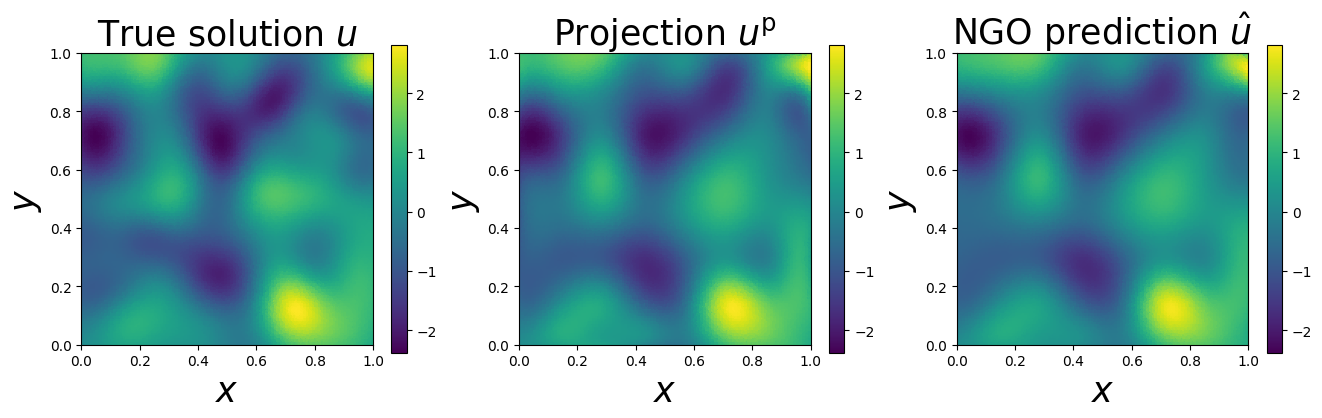

In [94]:
X, Y = np.mgrid[0:1:101*1j, 0:1:101*1j]
x = np.vstack([X.ravel(), Y.ravel()]).T


dataset = ManufacturedSolutionsSet(N_samples=1, variables=['x','x'], l_min=[l,l], l_max=[l,l])
theta = dataset.theta
f = dataset.f
etat = dataset.eta_yL
etab = dataset.eta_y0
gl = dataset.g_x0
gr = dataset.g_xL
u = dataset.u

u_exact = discretize_functions(u, x)
u_proj = projection.simforward(theta, f, etab, etat, gl, gr, x, u)
u_hat = modelNGO.simforward(theta, f, etab, etat, gl, gr, x, u)

size_title = 25
size_ticklabels = 15
size_axeslabels = 25

fig, axs = plt.subplots(1, 3, figsize=(16, 4))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0)

ax = axs[0]
fig = ax.tripcolor(x[:,0], x[:,1], u_exact[0], vmin=np.amin(u_exact[0]), vmax=np.amax(u_exact[0]))
ax.ticklabel_format(style='sci', scilimits=[-3,3])
ax.set_xlabel(r'$x$', fontsize=size_axeslabels)
ax.set_ylabel(r'$y$', fontsize=size_axeslabels)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_aspect('equal')
ax.set_title('True solution $u$', fontsize=size_title)
plt.colorbar(fig)

ax = axs[1]
fig = ax.tripcolor(x[:,0], x[:,1], u_proj[0], vmin=np.amin(u_exact[0]), vmax=np.amax(u_exact[0]))
ax.ticklabel_format(style='sci', scilimits=[-3,3])
ax.set_xlabel(r'$x$', fontsize=size_axeslabels)
ax.set_ylabel(r'$y$', fontsize=size_axeslabels)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_aspect('equal')
ax.set_title('Projection $u^{\mathrm{p}}$', fontsize=size_title)
plt.colorbar(fig)

ax = axs[2]
fig = ax.tripcolor(x[:,0], x[:,1], u_hat[0], vmin=np.amin(u_exact[0]), vmax=np.amax(u_exact[0]))
ax.ticklabel_format(style='sci', scilimits=[-3,3])
ax.set_xlabel(r'$x$', fontsize=size_axeslabels)
ax.set_ylabel(r'$y$', fontsize=size_axeslabels)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_aspect('equal')
ax.set_title('NGO prediction $\hat{u}$', fontsize=size_title)
plt.colorbar(fig)

plt.savefig("utrueprojpred.png", bbox_inches='tight')


plt.show()


### Plot of error versus test data length scale


In [95]:
N_samples = 10 #Number of test samples per length scale
l = np.array([0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]) #Length scales to test on
alpha = 0.05 #Plot confidence interval for the error bars. alpha=0.05 gives 95% confidence intervals
quadrature = GaussLegendreQuadrature(n_elements=(3,3), Q=(99,99)) #L2 error function quadrature
x = quadrature.xi
w = quadrature.w

Length scale: 0.05
Length scale: 0.1
Length scale: 0.2
Length scale: 0.3
Length scale: 0.4
Length scale: 0.5
Length scale: 0.6
Length scale: 0.7
Length scale: 0.8
Length scale: 0.9
Length scale: 1.0


C:\Users\s145608\AppData\Local\Temp\ipykernel_9560\3299052492.py:47: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string ".-" (-> linestyle='-'). The keyword argument will take precedence.
  plots.append(ax.errorbar(l, L2_scaled_avg[m], yerr=yerr[m], fmt=".-", capsize=6, ms=15, label=str(model), color=colors[m], linestyle=linestyles[m]))


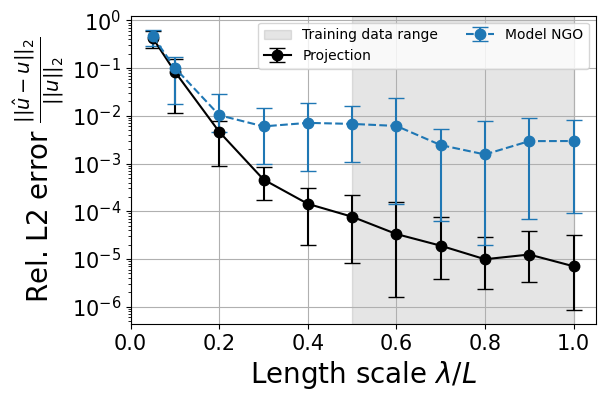

In [96]:
size_ticklabels = 15
size_axeslabels = 20
linestyles=['-','--']
colors = ['black','C0']

q_low = alpha/2
q_high = 1 - q_low

L2_scaled_avg = np.zeros((len(models),len(l)))
yerr = np.zeros((len(models),2,len(l)))

    
for i in range(len(l)):
    print("Length scale: "+ str(l[i]))
    dataset = ManufacturedSolutionsSet(N_samples=N_samples, variables=['x','x'], l_min=[l[i],l[i]], l_max=[l[i],l[i]])
    theta = dataset.theta
    f = dataset.f
    etat = dataset.eta_yL
    etab = dataset.eta_y0
    gl = dataset.g_x0
    gr = dataset.g_xL
    u = dataset.u
    m=0
    for model in models:
        u_exact = discretize_functions(u, x)
        u_hat = models[str(model)].simforward(theta, f, etab, etat, gl, gr, x, u)
        L2_scaled_array = weightedrelativeL2_set(w, u_hat, u_exact)
        L2_scaled_avg[m,i] = np.average(L2_scaled_array)
        q_l = np.quantile(L2_scaled_array, q_low)
        q_h = np.quantile(L2_scaled_array, q_high)
        yerr[m,:,i] = np.array([L2_scaled_avg[m,i] - q_l, -L2_scaled_avg[m,i] + q_h])
        m+=1

fig, ax = plt.subplots(1,1, figsize=(6, 4))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)

plots = []
plots.append(ax.axvspan(0.5,1, color='black', alpha=0.1, label='Training data range'))
m=0
ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.set_xlabel(r'Length scale $\lambda/L$', fontsize=size_axeslabels)
ax.set_ylabel(r'Rel. L2 error $\frac{||\hat{u}-u||_2}{||u||_2}$', fontsize=size_axeslabels)
ax.set_yscale('log')
ax.set_xlim(0, 1.05)
ax.grid()
for model in models:
    plots.append(ax.errorbar(l, L2_scaled_avg[m], yerr=yerr[m], fmt=".-", capsize=6, ms=15, label=str(model), color=colors[m], linestyle=linestyles[m]))
    m+=1
plt.legend(fontsize=10, ncols=2)

plt.savefig("errorversuslengthscale.png", bbox_inches='tight')
